In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from rom_am import POD, ROM, QUAD_MAN, DMDc, solid_ROM

In [19]:
import site
print(site.getsitepackages())

['/Users/azzeddinetiba/opt/anaconda3/lib/python3.9/site-packages']


In [ ]:
"/Users/azzeddinetiba/opt/anaconda3/lib/python3.9/site-packages/numpy/__config__.py

In [51]:
tr_disp_data = []
tr_load_data = []
test_disp_data = []
test_load_data = []

cutoff = 425
end_incr = 750
num_of_params = 4
include_subiters = True

tr_first_iters = []
tr_converged_iters = [] 
flat_tr_converged_iters = [] 
flat_tr_first_iters = [] 

tst_first_iters = []
tst_converged_iters = []
flat_tst_converged_iters = [] 
flat_tst_first_iters = [] 

param_map = []
tst_param_map = []

#folder_names = ["E5_data_10", "E5_data_0556", "E5_data_0667", "E5_data_18", "E5_data_15"]
#folder_names = ["E5_data_10",]
#folder_names = ["E10_refined_data/10", "E10_refined_data/12/", "E10_refined_data/135/", "E10_refined_data/15"]

folder_names = ["../Double_E10/10/", "../Double_E10/12/", "../Double_E10/14/"]
#folder_names = ["../Double_E10/14/", ]

num_of_params = len(folder_names)

j = 0
k = 0
l = 0
m = 0
n = 0
o = 0

for i in range(num_of_params):
    iters = np.load(folder_names[i]+"/coSimData/iters.npy")[:cutoff]
    iters[0] -= 1
    param_map.append(np.arange(0, iters.sum())+j)
    
    iters_tst = np.load(folder_names[i]+"/coSimData/iters.npy")[cutoff:end_incr]
    tst_param_map.append(np.arange(0, iters_tst.sum())+o)

    tr_first_iters.append(np.append(0, iters[:-1].cumsum().astype(int)))
    tr_converged_iters.append((iters.cumsum()-1).astype(int))
    flat_tr_converged_iters.append(tr_converged_iters[-1]+ k)
    flat_tr_first_iters.append(tr_first_iters[-1]+ l)

    tst_first_iters.append(np.append(0, iters_tst[:-1].cumsum().astype(int)))
    tst_converged_iters.append((iters_tst.cumsum()-1).astype(int))
    flat_tst_converged_iters.append(tst_converged_iters[-1]+ m)
    flat_tst_first_iters.append(tst_first_iters[-1]+ n)
    
    if include_subiters:
        tr_disp_data.append(np.load(folder_names[i]+"/coSimData/disp_data.npy")[:, :tr_converged_iters[-1][-1]+1])
        tr_load_data.append(np.load(folder_names[i]+"/coSimData/load_data.npy")[:, :tr_converged_iters[-1][-1]+1])

        test_disp_data.append(np.load(folder_names[i]+"/coSimData/disp_data.npy")[:, tr_converged_iters[-1][-1]+1:
                                                                                  tst_converged_iters[-1][-1]+1+tr_converged_iters[-1][-1]+1])
        test_load_data.append(np.load(folder_names[i]+"/coSimData/load_data.npy")[:, tr_converged_iters[-1][-1]+1:
                                                                                  tst_converged_iters[-1][-1]+1+tr_converged_iters[-1][-1]+1])

    else:            
        tr_disp_data.append(np.load(folder_names[i]+"/coSimData/disp_data.npy")[:, tr_converged_iters[-1]])
        tr_load_data.append(np.load(folder_names[i]+"/coSimData/load_data.npy")[:, tr_converged_iters[-1]])
        
        test_disp_data.append(np.load(folder_names[i]+"/coSimData/disp_data.npy")[:, tst_converged_iters[-1]])
        test_load_data.append(np.load(folder_names[i]+"/coSimData/load_data.npy")[:, tst_converged_iters[-1]])
        
    j += iters.sum()
    o += iters_tst.sum()
    k += tr_converged_iters[-1][-1]
    l += tr_first_iters[-1][-1]
    m += tst_converged_iters[-1][-1]
    n += tst_first_iters[-1][-1]

tr_disp_data = np.concatenate(tr_disp_data, axis=1)
tr_load_data = np.concatenate(tr_load_data, axis = 1)
test_disp_data = np.concatenate(test_disp_data, axis=1)
test_load_data = np.concatenate(test_load_data, axis = 1)
flat_tr_converged_iters = np.concatenate((flat_tr_converged_iters))

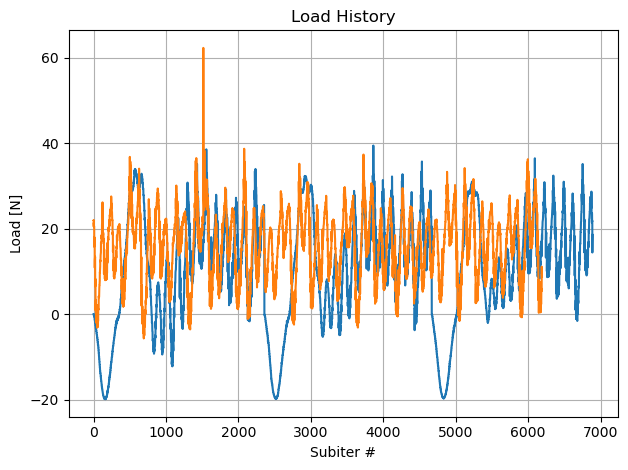

In [52]:
if include_subiters:
    plt.plot(tr_load_data[20, :]);
    plt.plot(test_load_data[20, :]);
    plt.xlabel("Subiter #");
else:
    plt.plot(np.arange(0., num_of_params*cutoff), tr_load_data[20, :]);
    plt.plot(np.arange(num_of_params*cutoff, num_of_params*end_incr), test_load_data[20, :]);
    plt.xlabel("Increment #");

plt.ylabel("Load [N]");
plt.title("Load History");

plt.grid();
plt.tight_layout();

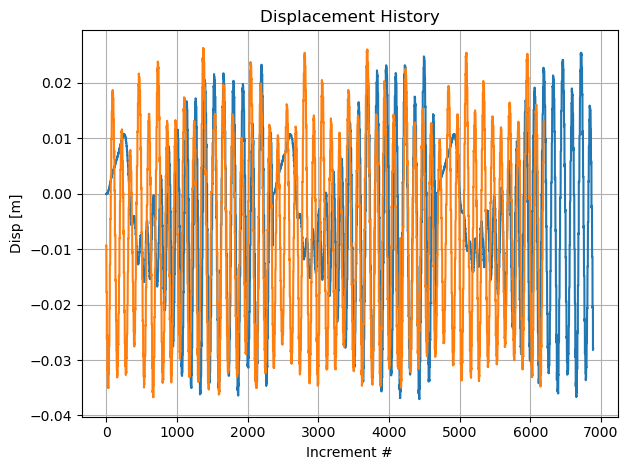

In [53]:
if include_subiters:
    plt.plot(tr_disp_data[20, :]);
    plt.plot(test_disp_data[20, :]);
    plt.xlabel("Subiter #");
else:
    plt.plot(np.arange(0., num_of_params*cutoff), tr_disp_data[20, :]);
    plt.plot(np.arange(num_of_params*cutoff, num_of_params*end_incr), test_disp_data[20, :]);
    plt.xlabel("Increment #");
    
plt.xlabel("Increment #");
plt.ylabel("Disp [m]");
plt.title("Displacement History");

plt.grid();
plt.tight_layout();

**Choice of best alpha**

In [15]:
from sklearn.linear_model import LassoLarsIC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor

In [42]:
modes_ = np.arange(15, 86, 5).astype(int)

residual_norm  = []
tst_residual_norm  = []
best_coeffs = np.empty((9, len(modes_)))

import random
ids_ = np.arange(0, tr_load_data.shape[1])
TR_ids = np.array(random.sample(range(tr_load_data.shape[1]), int(.95*tr_load_data.shape[1])))
TST_ids = np.setdiff1d(ids_, TR_ids)

TR_load_data = np.delete(tr_load_data, TST_ids, 1)
TR_disp_data = np.delete(tr_disp_data, TST_ids, 1)

TST_load_data = tr_load_data[:, TST_ids]
TST_disp_data = tr_disp_data[:, TST_ids]

for m in range(len(modes_)):

    print(" modes ", m)

    rom_model = solid_ROM()
    rom_model.train(TR_load_data, TR_disp_data, rank_pres=modes_[m], rank_disp=.9999, 
                    degree = 2, lasso=True, norm_regr=[False, True], quad_=True,);

    X = rom_model.saved_prs_cf_tr.T
    Y = rom_model.saved_disp_cf_tr.T
    residual_norm.append(np.linalg.norm(rom_model.model_regr.predict(X) - Y, ord = 2))

    for j in range(rom_model.disp_pod.kept_rank):
        best_coeffs[j, m] = rom_model.model_regr["multioutputregressor"].estimators_[j].alpha_
        
    y = rom_model.pred(TST_load_data).T
    yref = TST_disp_data.T

    tst_residual_norm.append(np.linalg.norm(yref - y, ord = 2))


 modes  0
 modes  1
 modes  2
 modes  3
 modes  4
 modes  5
 modes  6
 modes  7
 modes  8
 modes  9
 modes  10
 modes  11
 modes  12
 modes  13
 modes  14


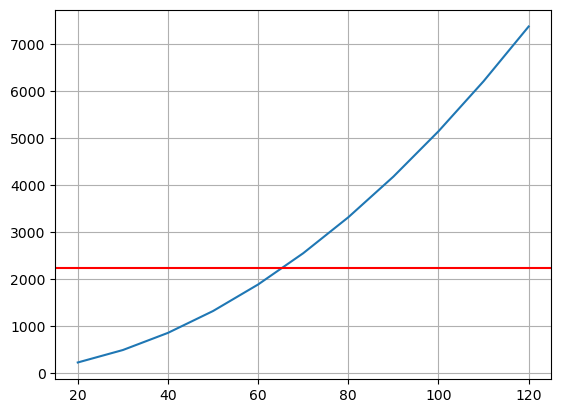

In [8]:
from scipy.special import binom
ms = np.arange(20, 130, 10)
res = []
for i in range(len(ms)):
    res.append(binom(2+ms[i],ms[i]))
plt.plot(ms, res);
plt.grid();
plt.axhline(2239, color = 'red');

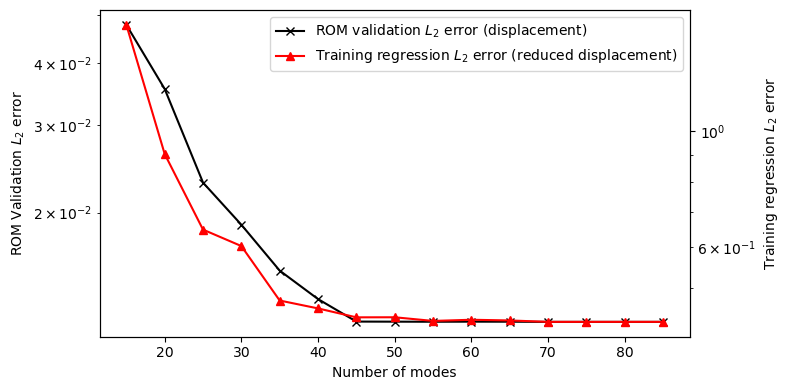

In [44]:

fig, ax1 = plt.subplots(figsize = (8, 4))

a = ax1.semilogy(modes_, tst_residual_norm, 'x-', label = "ROM validation $L_2$ error (displacement)", color = 'k');
ax1.set_xlabel("Number of modes");
ax1.set_ylabel(r"ROM Validation $L_2$ error");

ax2 = ax1.twinx()
ax2.set_ylabel(r"Training regression $L_2$ error");
b = ax2.semilogy(modes_, residual_norm, '^-', label = "Training regression $L_2$ error (reduced displacement)", color = 'red');

c = a+b
labs = [l.get_label() for l in c]
ax1.legend(c, labs, loc=0)

fig.tight_layout();
fig.savefig("../Figures/JFS/v_full_model/errors_modes.pdf", bbox_inches = 'tight');
np.save("../Figures/JFS/v_full_model/residuals.npy", residual_norm)
np.save("../Figures/JFS/v_full_model/test_residuals.npy", tst_residual_norm)
np.save("../Figures/JFS/v_full_model/best_coeffs.npy", best_coeffs)

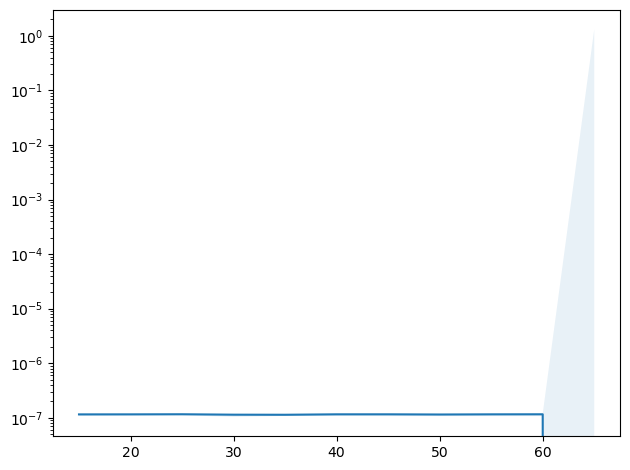

In [33]:
plt.semilogy(modes_, best_coeffs.mean(axis = 0));
plt.fill_between(modes_, best_coeffs.min(axis = 0), best_coeffs.max(axis = 0), alpha = .1);
plt.tight_layout();

10    :    50

12    :    40

14    :   35 - 50


all   :  45


In [57]:
out_mode = 0
ftrs = rom_model.model_regr["polynomialfeatures"].get_feature_names_out()


Mat = np.zeros((9, 56, 56))
for outmode in range(9):
    
    mat = np.zeros((56, 56))
    mat[0, 0] = np.all(rom_model.model_regr["multioutputregressor"].estimators_[outmode].coef_[0])

    for i in range(1, len(ftrs)):
            power = False

            after_x = ftrs[i].split("x",1)[1]
            try:
                first_mode = int(after_x)
                second_mode = -1
            except ValueError:
                try:
                    second_mode = int(after_x.split("x",1)[1])
                    first_mode = int(after_x[:2])
                except IndexError:
                    power = True
                    try:
                        first_mode = int(after_x[:2])
                        second_mode = first_mode
                    except ValueError:
                        first_mode = int(after_x[:1])
                        second_mode = first_mode

            first_mode += 1
            second_mode += 1
            if power:
                mat[first_mode, second_mode] = .5*np.all(rom_model.model_regr["multioutputregressor"].estimators_[outmode].coef_[i])
            else:
                mat[first_mode, second_mode] = np.all(rom_model.model_regr["multioutputregressor"].estimators_[outmode].coef_[i])

    mat = (mat+mat.T)
    Mat[outmode, :, :] = mat.copy()

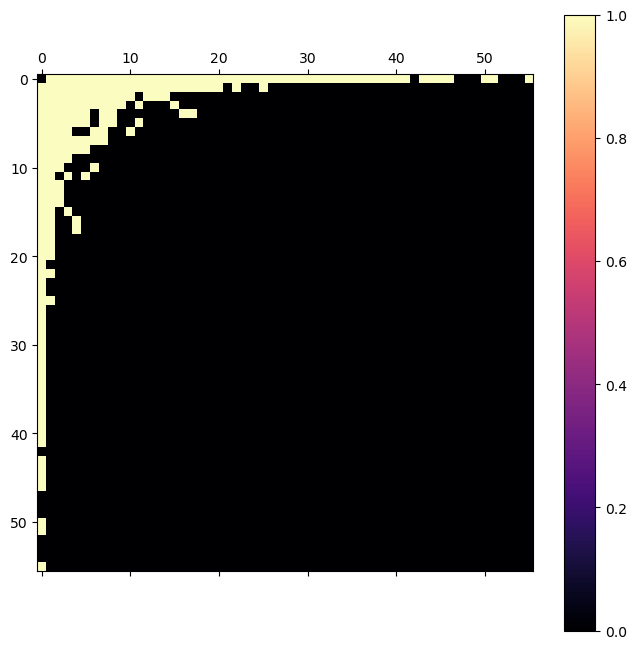

In [60]:
fig, ax = plt.subplots(figsize=(8, 8))
c = ax.matshow(Mat[-1, :, :], cmap = 'magma');
fig.colorbar(c);


In [61]:
#np.save("../Figures/JFS/v_full_model/Mat.npy", Mat);

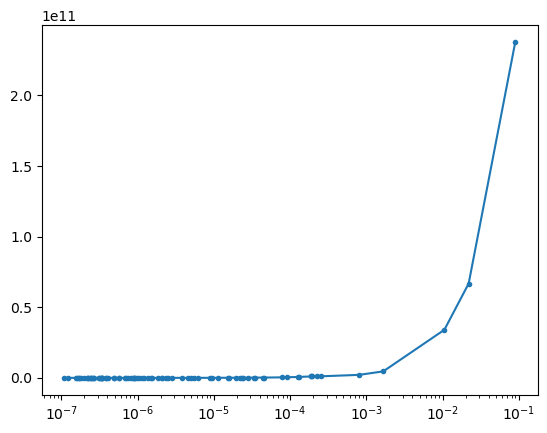

In [41]:

out_mode = 0
plt.semilogx(rom_model.model_regr["multioutputregressor"].estimators_[out_mode].alphas_, 
         rom_model.model_regr["multioutputregressor"].estimators_[out_mode].criterion_, '.-');
#plt.ylim(top = 1e10,);
#plt.xlim(right = .002,);

**Saving the best model**

In [54]:
rom_model = solid_ROM()
rom_model.train(tr_load_data, tr_disp_data, rank_pres=55, rank_disp=.9999, degree = 2, lasso=True,
                norm_regr=[False, True], norm=["l2", "minmax"], ids = None,
                quad_=True, alpha=1e-5, 
                map_used = np.load("../../DoubleFlap/coSimData/map_used.npy").T, 
               )

In [56]:
"""
import pickle 

with open('./Double_ROM_models/sol_rom_Double_E_10_full_lasso_MAP.pkl', 'wb') as outp:

    pickle.dump(rom_model, outp, pickle.HIGHEST_PROTOCOL)
""";

In [67]:
predicted_disp = rom_model.pred(test_load_data)

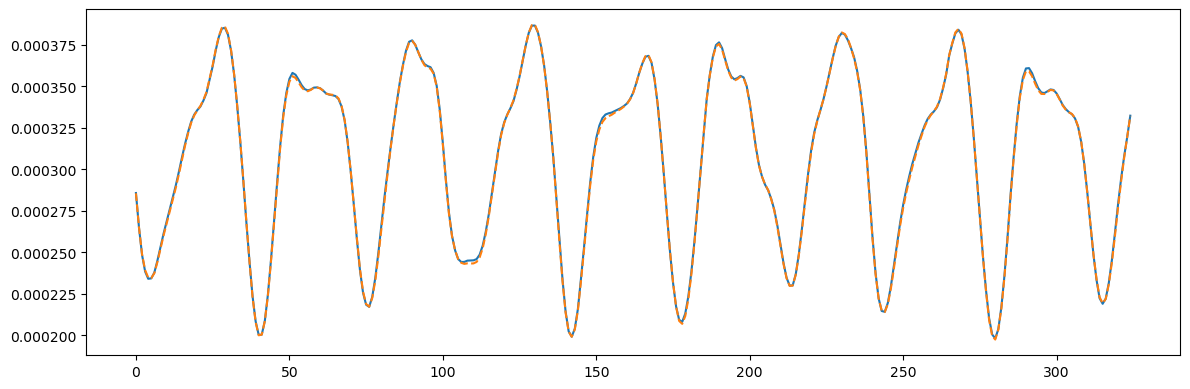

In [68]:
fig = plt.figure(figsize = (12, 4));
plt.plot(test_disp_data[:, tst_param_map[0]][2200, tst_converged_iters[0]]);
plt.plot(predicted_disp[:, tst_param_map[0]][2200, tst_converged_iters[0]], '--');
plt.tight_layout()

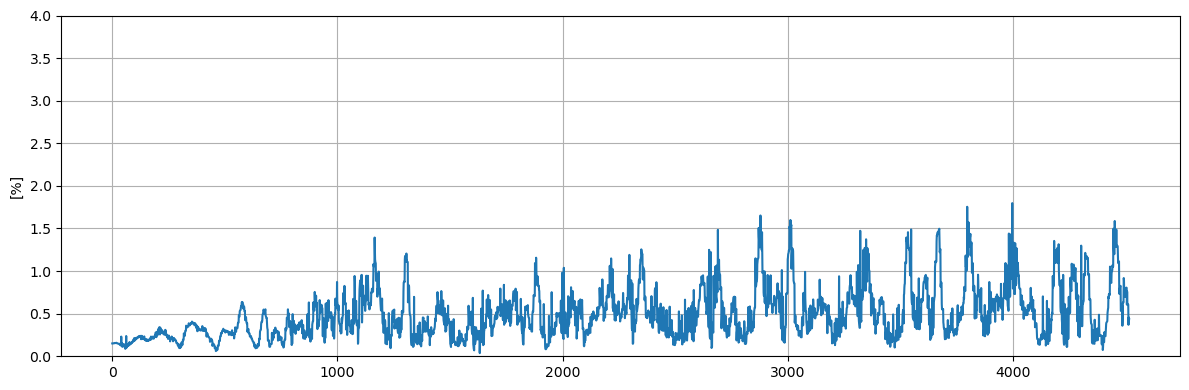

In [120]:
fig = plt.figure(figsize = (12, 4));
abs_err = np.linalg.norm(test_disp_data - predicted_disp, axis = 0)
rel_err = abs_err / np.linalg.norm(test_disp_data, axis = 0)
plt.plot(100 * rel_err,);
plt.ylabel("[%]");
#plt.ylim(top=4., bottom = 0.);
plt.tight_layout();
plt.grid();

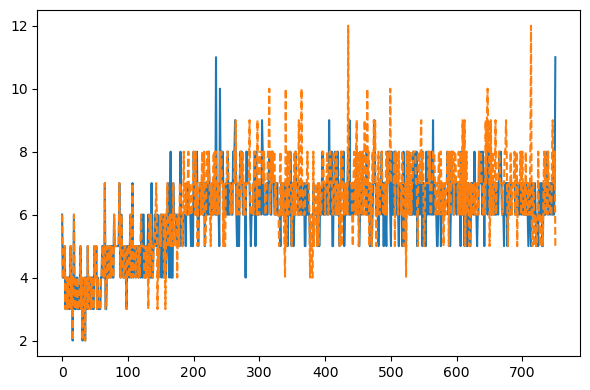

In [57]:
plt.figure(figsize=(6, 4))
nw_itr = np.load("../coSimData/iters.npy")
old_it = np.load("../Double_E10/07/coSimData/iters.npy")
plt.plot(old_it[:]);
plt.plot(nw_itr[:], '--');
plt.tight_layout();

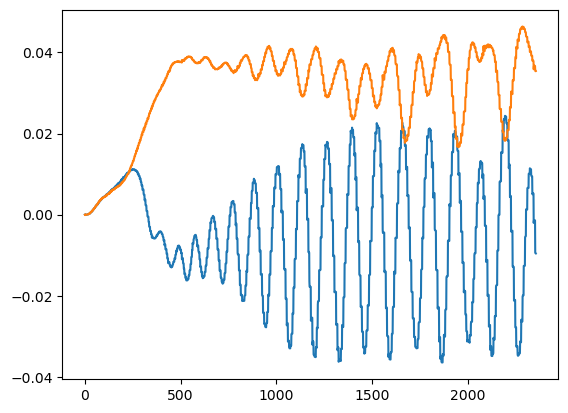

In [12]:
plt.plot(tr_disp_data[546, :]);
plt.plot(tr_disp_data[2976, :]);

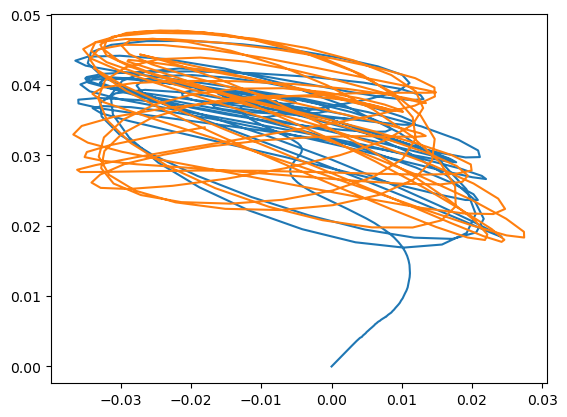

In [25]:
plt.plot(tr_disp_data[546, flat_tr_converged_iters], 
         tr_disp_data[2976, flat_tr_converged_iters]);
plt.plot(test_disp_data[546, flat_tst_converged_iters[0]], 
         test_disp_data[2976, flat_tst_converged_iters[0]]);

In [ ]:
np.load("../Double_E10/07/coSimData/total_solving_time.npy")

array([5959.01799703])

In [ ]:
np.load("../coSimData/total_solving_time.npy")

array([2947.63544393])

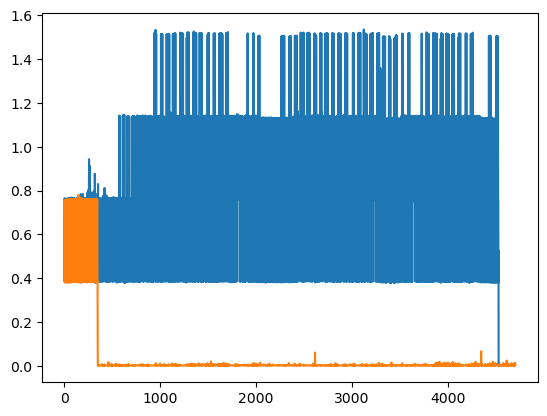

In [173]:
plt.plot((np.load("../Double_E10/07/coSimData/structure_time.npy")));
plt.plot((np.load("../Double_ROM_E10/07/coSimData/structure_time.npy")));